# Imports & reproducibility

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

from src.sir_rl.sir_sim import build_population, step_sir, run_sim
from src.sir_rl.rl_agent import train_q_learning, discretize_state, actions
from src.sir_rl.utils import plot_sir, plot_training

from src.sir_rl.interventions import apply_intervention_step, cost_step

# Reproducibility

In [2]:
SEED = 42
def set_seed(seed: int = SEED):
    np.random.seed(seed)
    random.seed(seed)

set_seed(SEED)

In [3]:
plt.rcParams.update({
    "figure.figsize": (8,5),
    "axes.grid": True,
    "font.size": 12
})

# Quick Run & Plots

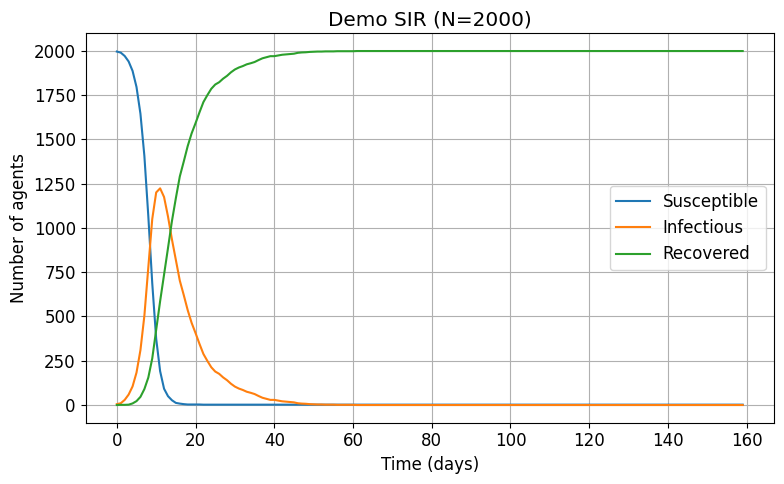

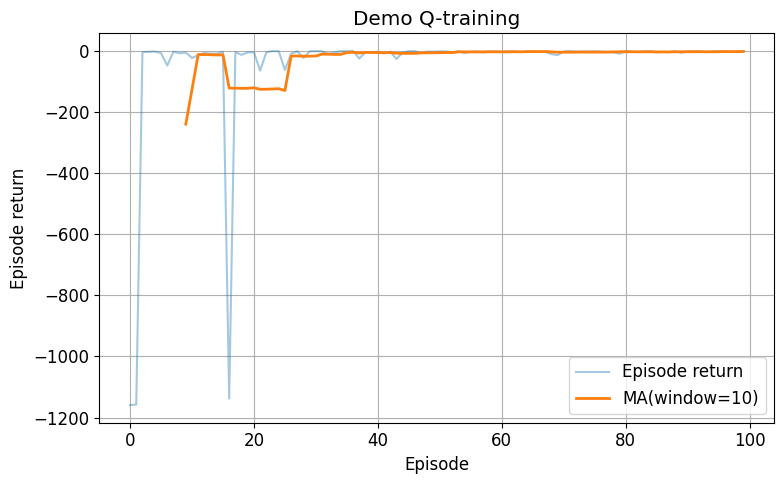

In [4]:
# Quick simulation plot
data = run_sim(N=2000, I0=5, beta=0.15, gamma=1/7, C=8, dt=1.0, T=160, seed=SEED)
plot_sir(data, title="Demo SIR (N=2000)")

# Quick RL train (short demo)
train_res = train_q_learning(N=1000, I0=5, beta=0.15, gamma=1/7, C=8, dt=1.0, T=120,
                             n_episodes=100, n_bins=6, t_bins=8)
plot_training(train_res["history"], window=10, title="Demo Q-training")

# Baseline Comparisons (single-run)

In [5]:
policy_idx = train_res["policy_idx"]  # from train_q_learning above

In [6]:
def greedy_policy(s_frac,i_frac,t_frac):
    s,i,tidx = discretize_state(s_frac,i_frac,t_frac, n_bins=6, t_bins=8)
    a_idx = int(policy_idx[s,i,tidx])
    return float(actions[a_idx])

In [7]:
def eval_policy(policy_fn, N, I0, beta, gamma, C, dt, T, lambda_epi=1.0, lambda_soc=0.1):
    np.random.seed(SEED + 999)
    from src.sir_rl.sir_sim import build_population
    states = build_population(N, I0)
    total_cost = 0.0
    for t in range(T):
        S_frac = (states == 0).sum() / N
        I_frac = (states == 1).sum() / N
        u = policy_fn(S_frac, I_frac, t/T)
        states, new_inf = apply_intervention_step(states, beta, gamma, C, dt, u, intervention="contacts")
        total_cost += cost_step(new_inf, u, lambda_epi, lambda_soc)
        if (states == 1).sum() == 0:
            break
    return total_cost, (states == 2).sum()

In [8]:
print("No intervention:", eval_policy(lambda s,i,t: 0.0, 1000,5,0.15,1/7,8,1.0,150))
print("Const u=0.5:", eval_policy(lambda s,i,t: 0.5, 1000,5,0.15,1/7,8,1.0,150))
print("Learned policy:", eval_policy(greedy_policy, 1000,5,0.15,1/7,8,1.0,150))

No intervention: (1179.0, np.int64(1000))
Const u=0.5: (1079.8250000000044, np.int64(991))
Learned policy: (2.500000000000001, np.int64(5))


# Unit Tests

In [9]:
def test_build_population():
    states = build_population(100, I0=3)
    assert len(states) == 100
    assert (states == 1).sum() == 3

In [10]:
def test_step_and_run():
    states = build_population(200, I0=2)
    next_states, new_inf = step_sir(states.copy(), beta=0.1, gamma=0.2, C=4, dt=1.0)
    assert next_states.shape == states.shape
    out = run_sim(200, I0=2, beta=0.1, gamma=0.2, C=4, dt=1.0, T=10, seed=0)
    assert "S" in out and "I" in out and "R" in out
    assert len(out["S"]) == len(out["I"])